<center><h1 style='font-family:consolas'>CSE1015 - Machine Learning Essentials Project</h1><h3 style='font-family:consolas'>Part B) Breast Cancer Segmentation</h3></center>

<h4 align='right'>Aayush Balaji &emsp;&emsp;&emsp; 20BAI1121<br>Sanjay Saju Jacob &emsp; 20BAI1139<br>Rohita Chakraborty &emsp;20BAI1213<br></h4>

#### Importing all the requisite python libraries.

In [ ]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

<br>

#### Declaring and implementing a function that reads the input features (ultrasound images and their respective masks) and stores them as a dictionary.

In [ ]:
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

<br>

#### Loading the benign training samples using the above declared function.

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = 'breast_cancer_segmentation\\Dataset_BUSI_with_GT\\benign'
                        , maskPath = 'breast_cancer_segmentation\\Dataset_BUSI_with_GT\\benign'
                         , shape = 256)

<br>

#### Similarly, loading the training malignant samples.

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = 'breast_cancer_segmentation\\Dataset_BUSI_with_GT\\malignant'
                        , maskPath = 'breast_cancer_segmentation\\Dataset_BUSI_with_GT\\malignant'
                         , shape = 256)

<br>

#### Plotting a sample ultrasound image which is stored in the dictionary, alongwith its mask, to check the authenticity.

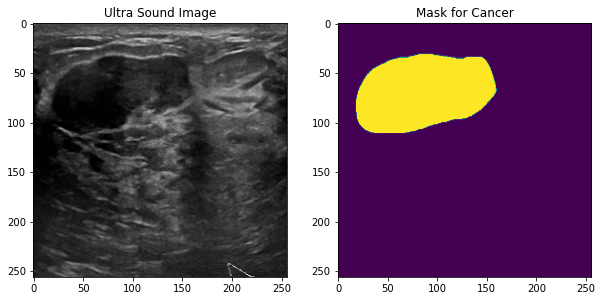

In [ ]:
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][3])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][3])
plt.title('Mask for Cancer')
plt.show()

<br>

#### Declaring the UNet model, which is basically an advanced Convolutional model by itself. In it, we perform Batch Normalization, choose the appropriate activation functions provide the most apt kernels chosen by us to perform the segmentation process.

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

<br>

#### This is a user defined function that returns a UNet model when fed with the input features (ultrasound images alongwith their masks). Just as we did in classification, here we create the different layers of the convolution, MaxPooling and Dropout (which on the whole comes out to be 9 layers - a depth required if we are seeking for an accuracy on the higher end).

In [ ]:
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

<br>

#### Here we call the function defined by us in the previous step and as done in the classification component as well, we compile the model before fitting it with the training data.

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 3))
model = GiveMeUnet(inputs, droupouts= 0.07)
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

<br>

#### This cell deals with fitting the model on the training dataset, where we individually provide the input images and its mask as two separate parameters, define the number of epochs and select the percentage of data to be used for validation.

In [ ]:
retVal = model.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), validation_split=0.20, epochs = 50, verbose = 1)

Epoch 1/50
17/17 [==============================] - 172s 10s/step - loss: 0.5975 - accuracy: 0.7657 - val_loss: 12.7448 - val_accuracy: 0.1528
Epoch 2/50
17/17 [==============================] - 163s 10s/step - loss: 0.4341 - accuracy: 0.9208 - val_loss: 9.5896 - val_accuracy: 0.2193
Epoch 3/50
17/17 [==============================] - 161s 9s/step - loss: 0.3868 - accuracy: 0.9241 - val_loss: 11.2474 - val_accuracy: 0.2024
Epoch 4/50
17/17 [==============================] - 165s 10s/step - loss: 0.3632 - accuracy: 0.9247 - val_loss: 3.0583 - val_accuracy: 0.5459
Epoch 5/50
17/17 [==============================] - 174s 10s/step - loss: 0.3467 - accuracy: 0.9247 - val_loss: 0.6778 - val_accuracy: 0.7879
Epoch 6/50
17/17 [==============================] - 192s 11s/step - loss: 0.3259 - accuracy: 0.9261 - val_loss: 2.1458 - val_accuracy: 0.5622
Epoch 7/50
17/17 [==============================] - 181s 11s/step - loss: 0.3114 - accuracy: 0.9264 - val_loss: 1.0392 - val_accuracy: 0.6044
Epoch

<br>

#### A standard plot describing the variation in the model value accuracy and value loss - epoch wise. We obtain a curve similar to the gradient descent one. The accuracy increases as the epoch is incremented and the loss decreases in that timeframe.

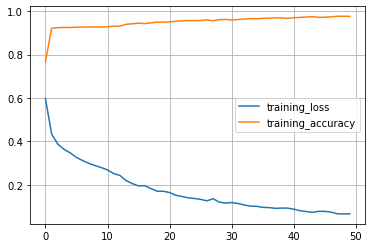

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

<br>

#### Here we define a function 'predict' that predicts the mask of an image provided to it. The 'Plotter' function plots the image fed to the model alongwith the predicted and actual masks.

In [ ]:
def predict (valMap, model, shape = 256):
    img = valMap['img'][0:482]
    mask = valMap['mask'][0:482]
    
    imgProc = img [0:482]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

<br>

#### Saving the model built by us in the above sequence of steps, as an h5 file so we needn't run it time and again.

In [ ]:
model.save('BreastCancerSegmentation.h5')

<br>

#### Loading the model which was saved in the previous cell.

In [ ]:
saved_model = keras.models.load_model('BreastCancerSegmentation.h5')

<br>

#### Loading the ultrasound image input from the testing dataset into the platform.

In [ ]:
framObjTest = {'img' : [],
           'mask' : []
          }
framObjTest = LoadData( framObjTest, imgPath = 'test_ML_Proj'
                        , maskPath = 'test_ML_Proj'
                         , shape = 256)

<br>

#### Deploying our very own user-defined UNet model to predict the masks of images from the testing dataset and seeing how well it performs against the actual masks provided for testing purposes.

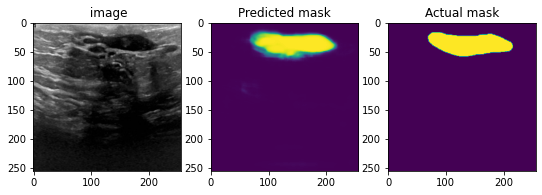

In [ ]:
pred, actuals, masks = predict(framObjTest, model)
Plotter(actuals[1], pred[1][:,:,0], masks[1])

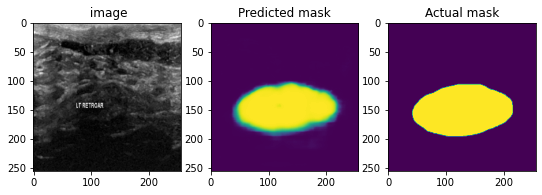

In [ ]:
pred, actuals, masks = predict(framObjTest, model)
Plotter(actuals[2], pred[2][:,:,0], masks[2])

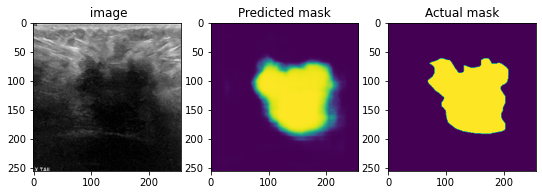

In [ ]:
pred, actuals, masks = predict(framObjTest, model)
Plotter(actuals[3], pred[3][:,:,0], masks[3])

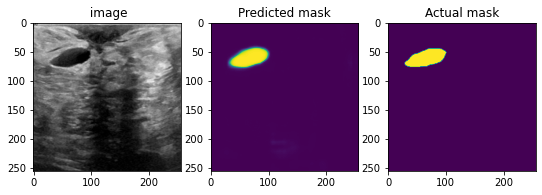

In [ ]:
pred, actuals, masks = predict(framObjTest, model)
Plotter(actuals[4], pred[4][:,:,0], masks[4])

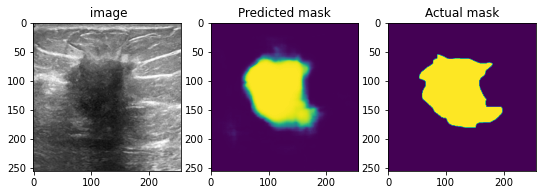

In [ ]:
pred, actuals, masks = predict(framObjTest, model)
Plotter(actuals[5], pred[5][:,:,0], masks[5])

<br>

### Hence we see that the predictions for the ultrascopic images are more or less accurate and match the actual masks, thereby helping in segmenting the tumor from the ultrascopy scan.

<center>----------</center>